## Multimodal Learning

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Dataset
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:

class FC_Autoencoder(nn.Module):
    def __init__(self, n_input, n_output, latent_variable_size, n_hidden=512):
        super(FC_Autoencoder, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.latent_variable_size = latent_variable_size
        self.n_hidden = n_hidden

        self.encoder = nn.Sequential(
            nn.Linear(self.n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, latent_variable_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_variable_size, n_hidden),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, self.n_output)
        )

    def forward(self, x):
        res = self.decoder(self.encoder(x))
        return res

In [16]:
def preprocess (Essentiality, Expression):

    dataset_processed = dict()
    common_cells = set(Expression.index)  & set(Essentiality.index)
    for cell in common_cells:

        dataset_processed[cell] = {
            "data_ess": torch.tensor(Essentiality.loc[cell]),
            "data_exp": torch.tensor(Expression.loc[cell])
        }
        
    ess_gene_list, exp_gene_list = list(Essentiality.columns), list(Expression.columns)
    return dataset_processed, ess_gene_list, exp_gene_list


class JointDataset(Dataset):
    def __init__(self, dataset, from_keys):
        
        self.data_ess = []
        self.data_exp = []
        self.cell_line = []

        self.keys = from_keys
        
        for cell in from_keys: #dataset.keys():
            self.data_ess.append(dataset[cell]["data_ess"])
            self.data_exp.append(dataset[cell]["data_exp"])
            self.cell_line.append(cell)
    
        self.data_ess = torch.stack(self.data_ess).float()
        self.data_exp = torch.stack(self.data_exp).float()
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, index):
        return self.data_ess[index], self.data_exp[index], self.cell_line[index]
    

def load_data(batch_size = None, val_split=False,drug=False):
    
    if drug:

        Essentiality = pd.read_csv("data/primary-screen-replicate-collapsed-logfold-change.csv"
                                  ).rename(columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')
        Essentiality = Essentiality.fillna(Essentiality.mean())
        # Essentiality.columns = Essentiality.columns.str.replace(r'[^a-zA-Z0-9]', '.', regex=True)

        # with open("data/top500_variable_drug.txt", 'r') as file:
        #     variable_drug = file.read().splitlines()
            
        # Essentiality = Essentiality[variable_drug]
        
    else:

        Essentiality = pd.read_csv("data/CRISPRGeneEffect.csv"
                                  ).rename(columns={"ModelID":
                                                    'CellLine'}).set_index('CellLine')  
        
        Essentiality.columns = [col.split(" ")[0] for col in Essentiality.columns]


    Expression = pd.read_csv("data/OmicsExpressionProteinCodingGenesTPMLogp1.csv").rename(
        columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')
    Expression.columns = [col.split(" ")[0] for col in Expression.columns]
    
    Joint_data, ess_gene_list, exp_gene_list = preprocess(Essentiality, Expression)

    random_cell_line = random.choice(list(Joint_data.keys()))
    n_input_ess = Joint_data[random_cell_line]["data_ess"].size(0)
    n_input_exp = Joint_data[random_cell_line]["data_exp"].size(0)

    if val_split:
        train_cells, val_cells = train_test_split(list(Joint_data.keys()), test_size=0.3, random_state=42)
        val_cells, test_cells = train_test_split(val_cells, test_size=0.5, random_state=42)
    
        train_data = JointDataset(Joint_data, train_cells)
        val_data =  JointDataset(Joint_data, val_cells)
        test_data =  JointDataset(Joint_data, test_cells)
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    else:
        train_cells, test_cells = train_test_split(list(Joint_data.keys()), test_size=0.2, random_state=42)
        
        train_data = JointDataset(Joint_data, train_cells)
        test_data =  JointDataset(Joint_data, test_cells)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        val_loader = None
        val_data = []

    print(f"Split:{len(train_data)}, Size of Val:{len(val_data)}, Size of Test: {len(test_data)}")
    print(f"Essentiality: {train_loader.dataset[0][0].shape} x {len(ess_gene_list)}")
    print(f"Expression: {train_loader.dataset[0][1].shape} x {len(exp_gene_list)}")

    return train_loader, val_loader, test_loader, n_input_ess, n_input_exp, ess_gene_list, exp_gene_list


### Model definitions 

In [6]:
def train(loader, model, opt="adam", alpha=0.5, beta=0.5, lr= 1e-3, device="cuda"):
    
    model.train()

    MSELoss = nn.MSELoss()

    if opt.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
    elif opt.lower() == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        
    elif opt.lower() == "adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=lr)
        
    elif opt.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Optimizer value error :{opt}")
       
    train_loss = 0
    for batch in loader:
        
        data_ess, data_exp = batch[0].to(device) , batch[1].to(device)
        pred_ess = model(data_exp)
        total_loss = MSELoss(data_ess, pred_ess)
        optimizer.zero_grad()        
        total_loss.backward()
        optimizer.step()
        
        train_loss += total_loss.item()
    
    train_loss /= len(loader)
    return train_loss, model


def evaluate(loader, model, device="cuda"):
    
    model.eval()
    MSELoss = nn.MSELoss()

    y_ess_pred = []
    y_ess_true = []

    val_loss = 0
    with torch.no_grad():
        for batch in loader:
            
            data_ess, data_exp = batch[0].to(device) , batch[1].to(device)
            pred_ess = model(data_exp)
            total_loss = MSELoss(data_ess, pred_ess)
            val_loss += total_loss.item()

            y_ess_pred.append(pred_ess)
            y_ess_true.append(data_ess)
    y_ess_pred = torch.cat(y_ess_pred, dim=0).detach().cpu().numpy()
    y_ess_true = torch.cat(y_ess_true, dim=0).detach().cpu().numpy()

    val_loss /= len(loader)
    return val_loss, y_ess_pred, y_ess_true


In [17]:
import time


latent_size = int(10e3) #1024
batch_size = 40
lr = 0.0001
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 0.4
beta = 0.5
opt="adam"

(
    train_loader, val_loader, test_loader, n_input_ess, n_input_exp, ess_gene_list, exp_gene_list
)= load_data(batch_size = batch_size, val_split=True, drug=True)

model = FC_Autoencoder(n_input_exp, n_input_ess, latent_size).to(device)


optimal_loss = float('inf')
for epoch in range(epochs):

    start_time = time.time()
    print(f"Epoch {epoch+1} of {epochs}")
    print("-------------------------------")
    
    train_loss, model_t = train(train_loader, model, opt=opt, alpha=alpha, beta=beta, lr=lr, device=device)
    val_loss, y_ess_pred, y_ess_true = evaluate(val_loader, model, device=device)

    if val_loss < optimal_loss:
        optimal_loss = val_loss
        torch.save(model_t.state_dict(), "drug/NN_baseline/model.pt")

    print(f'\tET: {time.time() - start_time}\n')

    print(f'\tTrain Loss: {train_loss}\n')
    print(f'\tVal Loss: {val_loss}\n')

/tmp/ipykernel_3476542/3082237624.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "data_ess": torch.tensor(Essentiality.loc[cell]),
/tmp/ipykernel_3476542/3082237624.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "data_exp": torch.tensor(Expression.loc[cell])


Split:390, Size of Val:84, Size of Test: 84
Essentiality: torch.Size([4686]) x 4686
Expression: torch.Size([19193]) x 19193
Epoch 1 of 50
-------------------------------
	ET: 0.46024489402770996

	Train Loss: 0.894539749622345

	Val Loss: 0.9271963238716125

Epoch 2 of 50
-------------------------------
	ET: 0.5865802764892578

	Train Loss: 0.7641817927360535

	Val Loss: 0.8980556726455688

Epoch 3 of 50
-------------------------------
	ET: 0.5552530288696289

	Train Loss: 0.6598679065704346

	Val Loss: 0.8570756713549296

Epoch 4 of 50
-------------------------------
	ET: 0.563988208770752

	Train Loss: 0.5728402972221375

	Val Loss: 0.8149237831433614

Epoch 5 of 50
-------------------------------
	ET: 0.5583183765411377

	Train Loss: 0.49853607416152956

	Val Loss: 0.7817454735438029

Epoch 6 of 50
-------------------------------
	ET: 0.49269771575927734

	Train Loss: 0.4431023508310318

	Val Loss: 0.7040393749872843

Epoch 7 of 50
-------------------------------
	ET: 0.505706310272

In [9]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

def get_corrcoef (data1 , data2, dim=0, corr="spearman"):
    
    if isinstance(data1, torch.Tensor):

        if data1.is_cuda:
            data1 = data1.cpu().detach().numpy()
            data2 = data2.cpu().detach().numpy()
        else:
            data1 = data1.detach().numpy()
            data2 = data2.detach().numpy()

    elif isinstance(data1, pd.DataFrame):
        data1 = data1.values
        data2 = data2.values
            
    if corr.lower() == "pearson":
        
        if dim == 0:
            corrcoef =[np.corrcoef(data1[:,i], data2[:,i])[0, 1] for i in range(data1.shape[1])]
            corrcoef = np.array(corrcoef)
            corrcoef = corrcoef[~np.isnan(corrcoef)]
        elif dim == 1:
            corrcoef =[np.corrcoef(data1[i,:], data2[i,:])[0, 1] for i in range(data1.shape[0])]
            corrcoef = np.array(corrcoef)
            corrcoef = corrcoef[~np.isnan(corrcoef)]
        else:
            raise ValueError(f"dim value erro: dim={dim}")
        
    elif corr.lower() == "spearman":
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            if dim == 0:
                corrcoef =[spearmanr(data1[:,i], data2[:,i])[0] for i in range(data1.shape[1])]
                corrcoef = np.array(corrcoef)
                corrcoef = corrcoef[~np.isnan(corrcoef)]
            elif dim == 1:
                corrcoef =[spearmanr(data1[i,:], data2[i,:])[0] for i in range(data1.shape[0])]
                corrcoef = np.array(corrcoef)
                corrcoef = corrcoef[~np.isnan(corrcoef)]
            else:
                raise ValueError(f"dim value erro: dim={dim}")

    else:
        raise ValueError(f"Correlation Name Error: {corr}")


    corrcoef = torch.tensor(corrcoef)

    highest_indices = torch.topk(corrcoef, int(0.1 * len(corrcoef)), largest=True).indices
    corrcoef10 = corrcoef[highest_indices] 

    return corrcoef, corrcoef10


def plot_corrcoef_boxplot(predicted_ess, original_ess, save_path=None,
                           merge_actionable_and_top10 =False, title="", show=False):
    
    drugs_corrcoef, drugs_corrcoef10 = get_corrcoef(predicted_ess, original_ess, dim=0)
    drugs_corrcoef, drugs_corrcoef10 = np.nan_to_num(drugs_corrcoef, nan=0.0, posinf=0.0, neginf=0.0), np.nan_to_num(drugs_corrcoef10, nan=0.0, posinf=0.0, neginf=0.0)

    cell_corrcoef, cell_corrcoef10 = get_corrcoef(predicted_ess, original_ess, dim=1)
    cell_corrcoef, cell_corrcoef10 = np.nan_to_num(cell_corrcoef, nan=0.0, posinf=0.0, neginf=0.0), np.nan_to_num(cell_corrcoef10, nan=0.0, posinf=0.0, neginf=0.0)
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        data = [drugs_corrcoef, drugs_corrcoef10, cell_corrcoef, cell_corrcoef10]
        labels = ['Drugs', 'Drugs 10%', 'Cells', 'Cells 10%']

        bp = plt.boxplot(data, labels=labels,
                         patch_artist=True, showfliers=True, notch=True, meanline=True)
        
        bp['boxes'][0].set_facecolor("lightblue")
        bp['boxes'][1].set_facecolor("lightblue")
        bp['boxes'][2].set_facecolor("brown")
        bp['boxes'][3].set_facecolor("brown")

    plt.ylabel('Correlation')
    plt.title(f'{title}', fontsize=10)
    
    if np.isfinite(np.median(drugs_corrcoef)):
        plt.text(0.65, np.median(drugs_corrcoef), round(np.median(drugs_corrcoef), 2), fontsize=8, rotation=90)

    if np.isfinite(np.median(drugs_corrcoef10)):
        plt.text(1.65, np.median(drugs_corrcoef10), round(np.median(drugs_corrcoef10), 2), fontsize=8, rotation=90)

    if np.isfinite(np.median(cell_corrcoef)):
        plt.text(2.65, np.median(cell_corrcoef), round(np.median(cell_corrcoef), 2), fontsize=8, rotation=90)

    if np.isfinite(np.median(cell_corrcoef10)):
        plt.text(3.65, np.median(cell_corrcoef10), round(np.median(cell_corrcoef10), 2), fontsize=8, rotation=90)
   
    if save_path:
        plt.savefig(save_path)

    if show:
        plt.show()


In [18]:
model.load_state_dict(torch.load("drug/NN_baseline/model.pt"))
y_ess_pred, y_ess_true = evaluate(test_loader, model, device=device)[1:]

In [20]:
#save the predicted and true values as df
pd.DataFrame(y_ess_pred, columns=ess_gene_list).to_csv("drug/NN_baseline/y_ess_pred.csv")
pd.DataFrame(y_ess_true, columns=ess_gene_list).to_csv("drug/NN_baseline/y_ess_true.csv")

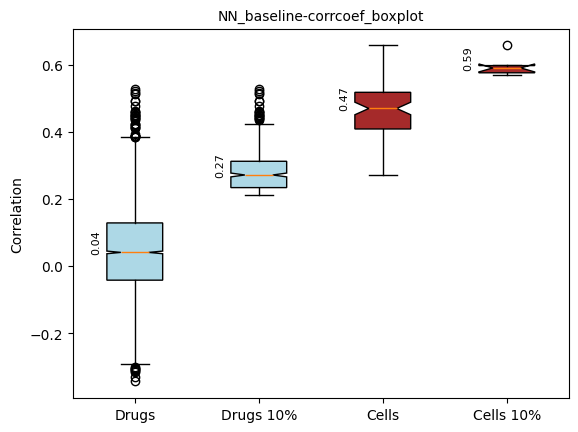

In [22]:
plot_corrcoef_boxplot(y_ess_pred, y_ess_true,
                     save_path="drug/NN_baseline/corrcoef_boxplot.pdf",
                      title="NN_baseline-corrcoef_boxplot",
                      show=True)